Tiago Lubiana, 2020; 
[CC-BY](https://creativecommons.org/licenses/by/4.0/)

# Preprocessing the single-cell files


So, single-cell files are big. They contain a lot of information. 
However not all information is really useful for analysis. 


Some of the single-cell readings contain [artifacts](https://en.wikipedia.org/wiki/Artifact_(error)) due to accumulation of debris, or due to cell death, for example. 


Some genes also are expressed in all cells, or none of the cells. These genes with *low variation* are not *that* interesting. 


In the code that follows, I will try and remove some of these "extra" fields, to make a lean dataset. That makes it easier to deal with, specially when running things  locally on laptops.

For that, I will use the [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) package. 

## Loading the package and the files

The first step is this (boring) part of importing the package and loading the files.

The import calls load different bits of python code written by other people. These are called modules. 
They provide us with the commands ("functions") for the analysis.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

These are just settings. Don't try to understand them, really, I just copied and pasted from the tutorial. Does not matter.

In [2]:
sc.settings.verbosity = 3            
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')



scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


Now I will just load the files:


In [3]:
results_file = 'resutls/msc.h5ad'  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_h5(
    '../data/GSE115149_filtered_gene_bc_matrices_h5.h5')                    

reading ../data/GSE115149_filtered_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


In [5]:
adata.var_names_make_unique() 
adata

AnnData object with n_obs × n_vars = 4808 × 32738
    var: 'gene_ids'

I am following scanpy's tutorial. The first step is to check which genes are highly expressed accross cells in the dataset:

normalizing counts per cell
    finished (0:00:00)


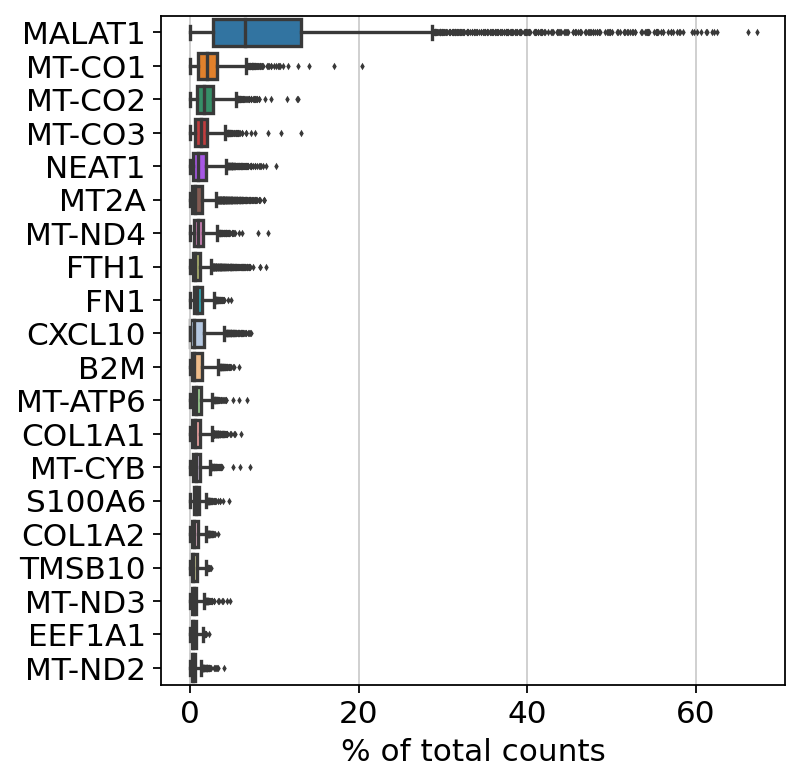

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### A little task for you

Do you notice something in common about the genes highly expressed in the dataset?

Search a bit about some of those genes and try to draw a few inferences. 

(ex: Search for MALAT1, MT-CO1, MT-ND4 and CXCL10)

You will notice that we have a mix of [housekeeping genes](https://en.wikipedia.org/wiki/Housekeeping_gene) and genes that seem to have more specific functions. 

## Filtering the dataset to keep only good data points


That was just for fun. The next step will be to remove cells with data for less than  200 genes. 

These data points are deemed to have low quality. 

This is a  [free parameter](https://en.wikipedia.org/wiki/Free_parameter) that we choose based on experience. 

It could be 100, it could be 300, really, it depends  a bit on the gut feeling of their analyst. 

I will use 200 because that is the number on the [tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). 

In [7]:
sc.pp.filter_cells(adata, min_genes=200)

I will do the same for the genes. If a gene is expressed in less than 5 cells, I do not care about it now. 

This is also a free paramenter. The [rule of thumb](https://en.wikipedia.org/wiki/Rule_of_thumb) is 1/1000 of the cells. 

As we have about 5k cells, I will set it to 5.

In [8]:
sc.pp.filter_genes(adata, min_cells=5)

filtered out 16043 genes that are detected in less than 5 cells


In [9]:
adata

AnnData object with n_obs × n_vars = 4808 × 16695
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Wow, the dataset is half the size now! That is already saves some space in the memory. 


## Removing cells with high mithocondrial content

Citing the citation in the scanpy tutorial:

"Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

    High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane. "
    
    
As you might have figured out, the mitochondrial genes are the ones starting with "MT-". Let's do something about that.

I will use some fancy code to group these genes and then calculate the percentage of the transcriptome occupied by them. 

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

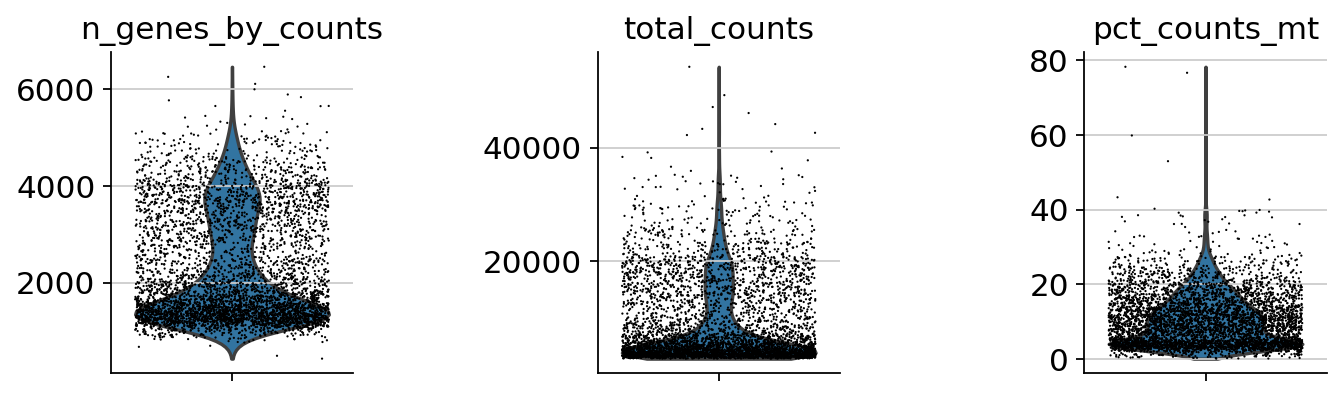

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Nice plots! These are just fancy ways of looking at: 
- the number of genes per cell,
- the total "counts" of all genes per cell
- the percentage of gene expression counts that belong to mithocondrial genes.

Noice. Now we will do as the tutorial says and "Remove cells that have too many mitochondrial genes expressed or too many total counts."

For this, we will just take a look at a few more plots and pick numbers that seem reasonable.

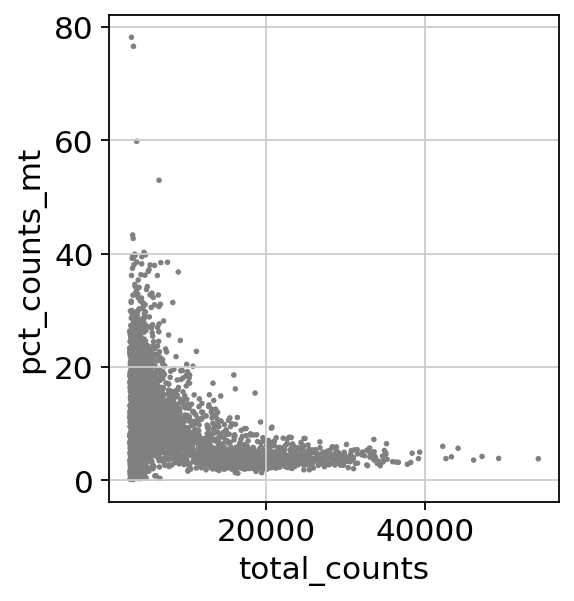

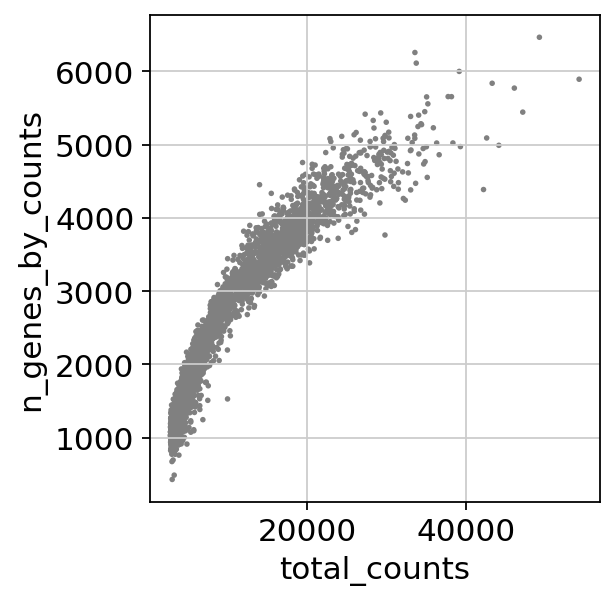

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')



The threshold for mitochondrial content in the tutorial is of 5%.

However, notice in the plot above that almost all our cells have more than 5% of mitochondrial content! 

This is true, biological data. And of course, the mitochondrial content depends on things like cell type and the details of the methodology. 

Some cells might actually have a high mitochondial content. 

It makes sense to exclude all cells with >20% content. Again, this is arbitrary and based on gut feeling. 

## Another task for you 

Go in the [scanpy tutorial] and look for these plots there. What are the differences? What are the similarities?

Pay attention to the scale of the x and y axis. Try to understand why I choose the 20%. 

(But don't try too much, really, I can't stress this enough: parameter choice involves a lot of gut feeling)

In [13]:
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata

View of AnnData object with n_obs × n_vars = 4327 × 16695
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Okay, so this quality control step removed 500 of our cells. We have to be ruthless sometimes. 

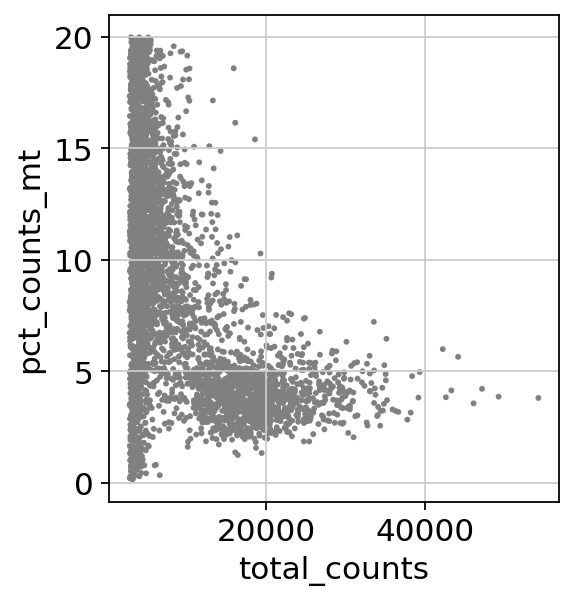

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')


Oh okay, now looking again at the plot, we can see actually two distinct populations: one with low counts and/or high mitochondrial content, and another with more counts and less mitochondrial content. 

Which one of them looks as true, reliable data? 

Well I know which ones I trust, so I will filter again for cells wih less than 7% mitochondrial content.

The people that make these tutorials know what they are doing and I will land a bit more close to their advice

In [17]:
adata = adata[adata.obs.pct_counts_mt < 12, :]
adata

View of AnnData object with n_obs × n_vars = 3085 × 16695
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

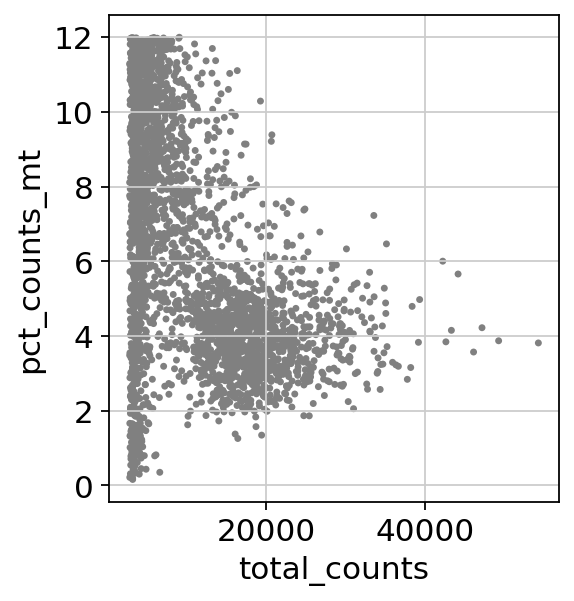

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')


## One more task for you

How does this cell removal step can affect your results? If you know that the cells you want to process have a high mitochondrial content, could you do this step? 

# Normalizing the dataset

Before actually analysing the dataset, we still have a few steps to go. The first  will be a _normalization_ step. 

We will do some things  that compare genes to each other. But some genes have a very high expression, and others a  very low expression .

That is okay, that is how biology works, and how experimental variation works. 

However this causes a few math problems, so we just scale the data to make each cell have 10 000 total counts. 


For example, if Cell 1 had 5 000 total counts, and 100 counts for gene A, in the final table, it will have 200 scaled counts. 

If Cell 2 had 20 000 total counts, and 300 counts for gene A, in the final table, it will have 150 scaled counts. 


__THIS IS CONCEPTUALLY VERY IMPORTANT__

We are not looking anymore at the level of expression, but at the _proportion_ of the transcriptome these genes contribute to. 

There are many things that this implies.

## A challenging optional task

Think a bit about the pros and cons of scaling expression. This is hard, and there are no answers. Really, this is hard, cutting-edge stuff. 



In [19]:
sc.pp.normalize_total(adata, target_sum=1e5)

normalizing counts per cell
    finished (0:00:00)


/home/lubianat/.local/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Okay, so the last step in this preprocessing will be to turn the expression to logarithm scale. 

This is a data transformation which changes the scales and relations of things. 

Lets take gene B in two cells again, Cell 1 and Cell 2. 

Before a log2 transformation, Cell 1 has expression count for gene B of 16. Cell 2, has a count of 4.

That is, Cell 1 has 4 times the expression of Cell 2.

If we apply a log2 transformation, 16 becomes 4 (2^4) and 4 becomes 2 (2^2) 

Now Cell 1 has only 2 times the expression of Cell 2! 


It is a transformation that kind of squooshes big numbers, and make things closer.

### Why to log transform??

This is empirical: people did it and it improved results. 

In [20]:
sc.pp.log1p(adata)

# Last step I promise you

The last step I will do here is to keep only the highly variable genes. 

Why? Well because genes with low variability are less interesting (generally). 

We like things that are expressed in some cells, but not others. We want to find _cell markers_. 

Let's identify the highly variable genes:

(a lot of scanpy parameters too. They are just the standard ones)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


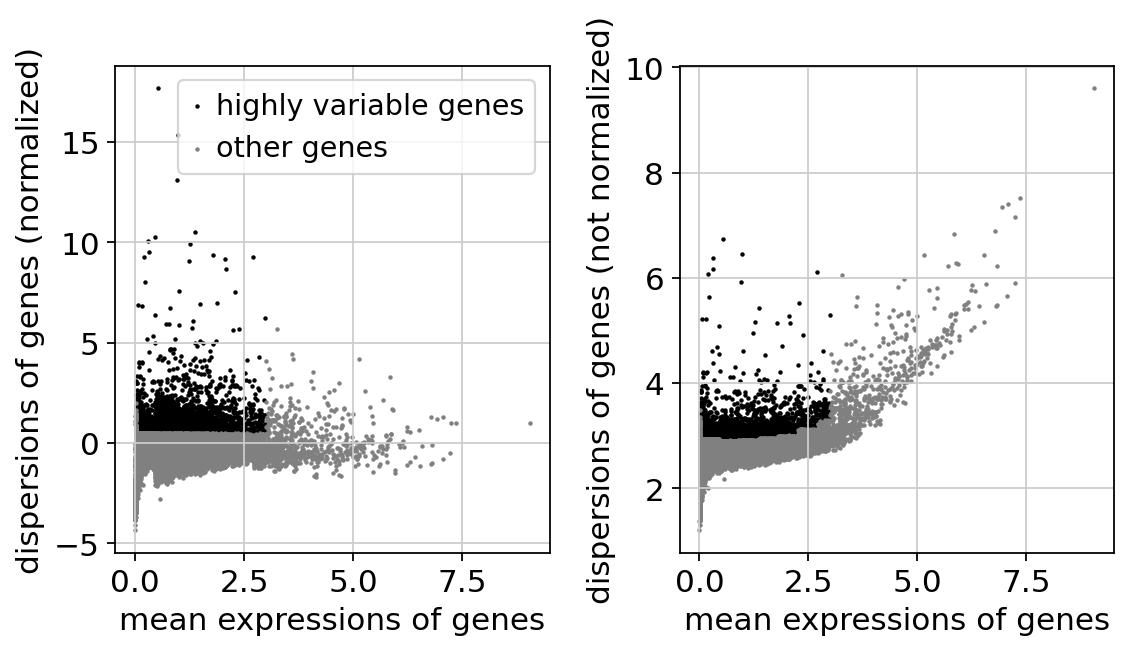

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

We will just keep the highly variable genes. 

__CAUTION: THIS MAY REMOVE INTERESTING GENES__

If this removes any gene that you are really interested in, we can comeback and re-do the preprocessing. 

In [24]:
adata = adata[:, adata.var.highly_variable]

In [47]:
adata

View of AnnData object with n_obs × n_vars = 3085 × 4306
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

The scanpy tutorial does many other nice things. 

However, it might be too much for starters, and scOrange has likely a better interface for exploring the data. 

I will save the clean dataset as a table (.mtx) and share it with you. 

The annotations are also saved in the results folder. 


In [46]:
from scipy import sparse, io
io.mmwrite("../results/preprocessedtest_and_filtered_and_normalized_GSE115149.mtx", adata.X)
adata.write_csvs("../results")


writing .csv files to ../results
